# Describing function analysis
Richard M. Murray, 27 Jan 2021

This Jupyter notebook shows how to use the `descfcn` module of the Python Control Toolbox to perform describing function analysis of a nonlinear system.  A brief introduction to describing functions can be found in [Feedback Systems](https://fbsbook.org), Section 10.5 (Generalized Notions of Gain and Phase).

In [1]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import math

## Built-in describing functions
The Python Control Toobox has a number of built-in functions that provide describing functions for some standard nonlinearities. 

### Saturation nonlinearity

A saturation nonlinearity can be obtained using the `ct.saturation_nonlinearity` function.  This function takes the saturation level as an argument.

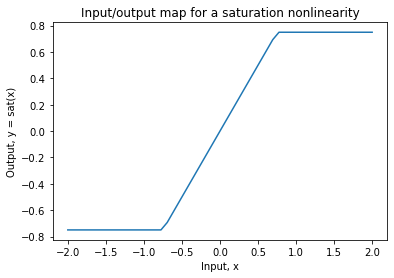

In [2]:
saturation=ct.saturation_nonlinearity(0.75)
x = np.linspace(-2, 2, 50)
plt.plot(x, saturation(x))
plt.xlabel("Input, x")
plt.ylabel("Output, y = sat(x)")
plt.title("Input/output map for a saturation nonlinearity");

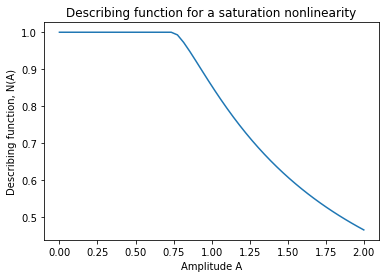

In [3]:
amp_range = np.linspace(0, 2, 50)
plt.plot(amp_range, ct.describing_function(saturation, amp_range))
plt.xlabel("Amplitude A")
plt.ylabel("Describing function, N(A)")
plt.title("Describing function for a saturation nonlinearity");

### Backlash nonlinearity
A friction-dominated backlash nonlinearity can be obtained using the `ct.friction_backlash_nonlinearity` function.  This function takes as is argument the size of the backlash region.

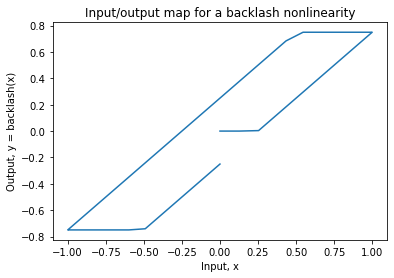

In [4]:
backlash = ct.friction_backlash_nonlinearity(0.5)
theta = np.linspace(0, 2*np.pi, 50)
x = np.sin(theta)
plt.plot(x, [backlash(z) for z in x])
plt.xlabel("Input, x")
plt.ylabel("Output, y = backlash(x)")
plt.title("Input/output map for a friction-dominated backlash nonlinearity");

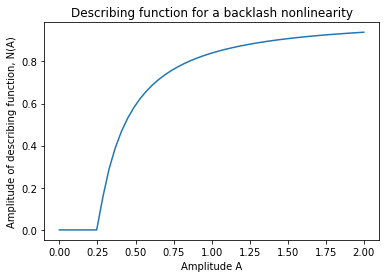

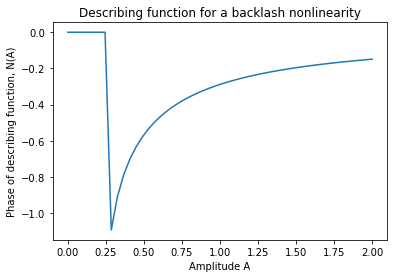

In [5]:
amp_range = np.linspace(0, 2, 50)
N_a = ct.describing_function(backlash, amp_range)

plt.figure()
plt.plot(amp_range, abs(N_a))
plt.xlabel("Amplitude A")
plt.ylabel("Amplitude of describing function, N(A)")
plt.title("Describing function for a backlash nonlinearity")

plt.figure()
plt.plot(amp_range, np.angle(N_a))
plt.xlabel("Amplitude A")
plt.ylabel("Phase of describing function, N(A)")
plt.title("Describing function for a backlash nonlinearity");

### User-defined, static nonlinearities

In addition to pre-defined nonlinearies, it is possible to computing describing functions for static nonlinearities.  The describing function for any suitable nonlinear function can be computed numerically using the `describing_function` function.

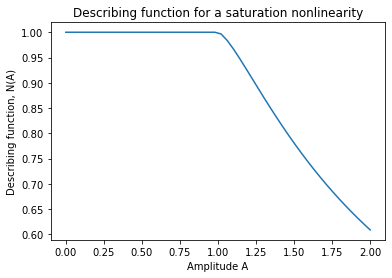

In [6]:
# Define a saturation nonlinearity as a simple function
def my_saturation(x):
    if abs(x) >= 1:
        return math.copysign(1, x)
    else:
        return x

amp_range = np.linspace(0, 2, 50)
plt.plot(amp_range, ct.describing_function(my_saturation, amp_range).real)
plt.xlabel("Amplitude A")
plt.ylabel("Describing function, N(A)")
plt.title("Describing function for a saturation nonlinearity");

## Stability analysis using describing functions
Describing functions can be used to assess stability of closed loop systems consisting of a linear system and a static nonlinear using a Nyquist plot.

### Limit cycle position for a third order system with saturation nonlinearity

Consider a nonlinear feedback system consisting of a third-order linear system with transfer function $H(s)$ and a saturation nonlinearity having describing function $N(a)$.  Stability can be assessed by looking for points at which 

$$
H(j\omega) N(a) = -1$$

The `describing_function_plot` function plots $H(j\omega)$ and $-1/N(a)$ and prints out the the amplitudes and frequencies corresponding to intersections of these curves. 

[(3.343977839598768, 1.4142156916757294)]

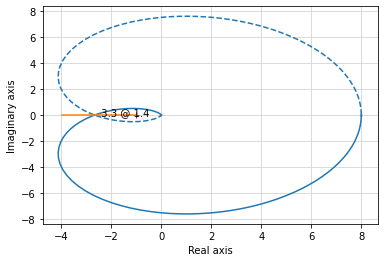

In [7]:
# Linear dynamics
H_simple = ct.tf([8], [1, 2, 2, 1])
omega = np.logspace(-3, 3, 500)

# Nonlinearity
F_saturation = ct.saturation_nonlinearity(1)
amp = np.linspace(00, 5, 50)

# Describing function plot (return value = amp, freq)
ct.describing_function_plot(H_simple, F_saturation, amp, omega)

The intersection occurs at amplitude 3.3 and frequency 1.4 rad/sec (= 0.2 Hz) and thus we predict a limit cycle with amplitude 3.3 and period of approximately 5 seconds.

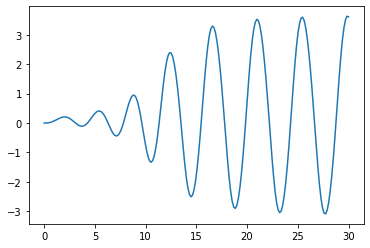

In [8]:
# Create an I/O system simulation to see what happens
io_saturation = ct.NonlinearIOSystem(
    None,
    lambda t, x, u, params: F_saturation(u),
    inputs=1, outputs=1
)

sys = ct.feedback(ct.tf2io(H_simple), io_saturation)
T = np.linspace(0, 30, 200)
t, y = ct.input_output_response(sys, T, 0.1, 0)
plt.plot(t, y);

### Limit cycle prediction with for a time-delay system with backlash

This example demonstrates a more complicated interaction between a (non-static) nonlinearity and a higher order transfer function, resulting in multiple intersection points.

[(0.6260158833531679, 0.31026194979692245),
 (0.8741930326842812, 1.215641094477062)]

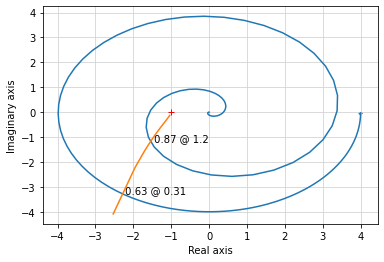

In [9]:
# Linear dynamics
H_simple = ct.tf([1], [1, 2, 2, 1])
H_multiple = H_simple * ct.tf(*ct.pade(5, 4)) * 4
omega = np.logspace(-3, 3, 500)

# Nonlinearity
F_backlash = ct.friction_backlash_nonlinearity(1)
amp = np.linspace(0.6, 5, 50)

# Describing function plot
ct.describing_function_plot(H_multiple, F_backlash, amp, omega, mirror_style=False)